In [1]:
import requests
import csv
import matplotlib.pyplot as plt
from collections import Counter

mode = 'test'
# mode = 'production'

test_url = 'https://side-n-top-default-rtdb.firebaseio.com/test/.json'
production_url = 'https://side-n-top-default-rtdb.firebaseio.com/events/.json'

test_file = 'test.csv'
production_file = 'production.csv'

url = test_url if mode == 'test' else production_url
out_put_file = test_file if mode == 'test' else production_file

In [2]:
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    # print(data)
else:
    print("Failure Request：", response.status_code)

In [3]:
# Extract all events into a csv
all_events = []
for key, value in data.items():
    if isinstance(value, dict) and 'events' in value:
        all_events.extend(value['events'])
        
fieldnames = all_events[0].keys()
with open(out_put_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_events)

print(f"CSV file saved as {out_put_file} with {len(all_events)} rows.")

CSV file saved as test.csv with 55 rows.


In [4]:
# Group events by their SessionID
grouped_events = {}

for event in all_events:
    session_id = event.get('sessionId')
    if session_id not in grouped_events:
        grouped_events[session_id] = []
    grouped_events[session_id].append(event)

for session_id, events in grouped_events.items():
    print(f"There are {len(events)} events in SessionID: {session_id}")

There are 3 events in SessionID: 0df28345-faf7-4b29-8e7f-4a49303dcc4d
There are 5 events in SessionID: 9d2f24e6-5915-41ca-83f7-cf8270c83e8a
There are 4 events in SessionID: 3b57e861-9e58-4d81-9989-e1bf6eee0c32
There are 1 events in SessionID: babe9638-4c83-44b5-b40c-8231c1ac147a
There are 3 events in SessionID: 0ec8054c-342f-42d6-9ed6-25d198265e06
There are 4 events in SessionID: 0137a657-8857-4b92-81fa-aab685e8ef40
There are 5 events in SessionID: 1637d041-02c2-4eeb-ae1c-5fb49dcc6ef8
There are 5 events in SessionID: 07f4af3d-8e47-431c-9fb4-0e750f88de75
There are 3 events in SessionID: d9137ca6-e55d-4363-a326-03f6d5880613
There are 5 events in SessionID: 91c5dac6-7a0f-45ee-b925-52ec45418815
There are 5 events in SessionID: 04a965bf-a77d-46a5-b14e-8d78cd9dae81
There are 5 events in SessionID: e31e9ba6-852a-4621-a73c-998f8fb6927a
There are 4 events in SessionID: 8bf8bed9-826b-44bc-99f4-3c2052ee0684
There are 3 events in SessionID: d11db29b-712f-493f-baef-d5654c5c5b28


In [5]:
topdown_ratio_list = []
session_time_list = []

level_dict = {'Level0' : 0, 'Level1' : 1, 'Level2' : 2}
total_topdown_time_by_level = [0, 0, 0]
total_time_by_level = [0, 0, 0]
average_topdown_time_by_level = [0, 0, 0]

for session_id, events in grouped_events.items():
    if len(events) < 2:
        continue

    # Sort events by timestamp
    events = sorted(events, key=lambda x: x.get('timestamp', 0))
    level_id = events[0].get('levelId')
    level_idx = level_dict[level_id]
    
    is_topdown = False
    topdown_time = 0
    platformer_time = 0
    for i in range(1, len(events)):
        event = events[i]
        prev_event = events[i - 1]
        
        # Skip start event
        if event.get('eventType') == 'Start':
            continue

        # Sum topdown_time or platformer_time
        time_interval = event.get('timestamp', 0) - prev_event.get('timestamp', 0)
        if event.get('eventType') in ['Lose', 'Win', 'Shift']:
            if is_topdown:
                topdown_time += time_interval
            else:
                platformer_time += time_interval

            # Shift on shift event
            if event.get('eventType') == 'Shift':
                is_topdown = not is_topdown

    session_time = topdown_time + platformer_time
    session_time_list.append(session_time/1000)

    ratio = topdown_time / session_time if session_time != 0 else 1
    topdown_ratio_list.append(ratio)

    total_topdown_time_by_level[level_idx] += topdown_time
    total_time_by_level[level_idx] += topdown_time + platformer_time

print(topdown_ratio_list)
print(session_time_list)

for i in range(len(total_time_by_level)):
    average_topdown_time_by_level[i] = total_topdown_time_by_level[i] / total_time_by_level[i] if total_time_by_level[i] != 0 else 1
print(average_topdown_time_by_level)

[0.013245033112582781, 0.30155196539880424, 0.7638969143649601, 0.5772997551591466, 0.18853759529429975, 0.351961950059453, 0.35808851342831927, 0.8227921048840224, 0.694562087074369, 0.6820243833286079, 0.40763546798029554, 0.7354806684683691, 0.6926749420270086]
[14.949, 15.722, 34.612, 11.436, 25.841, 2.523, 15.862, 6.941, 5.903, 21.162, 4.06, 18.131, 7.331]
[0.6422459604056707, 0.3036912751677852, 0.351961950059453]


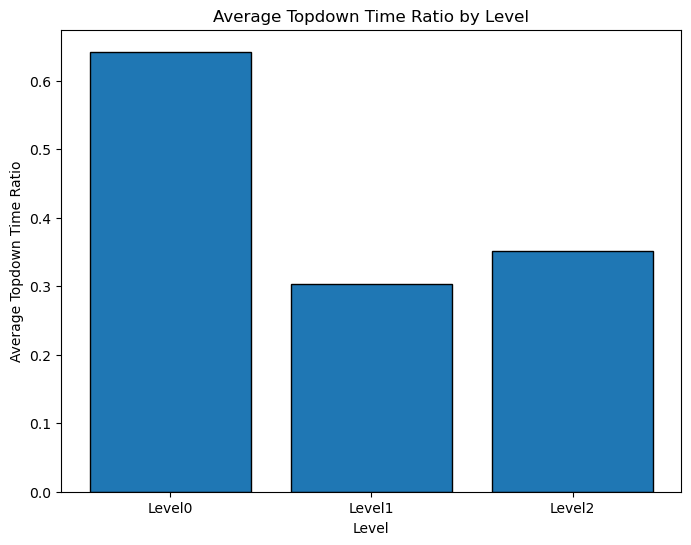

In [6]:
levels = list(level_dict.keys())  # e.g., ['Level0', 'Level1', 'Level2']

plt.figure(figsize=(8, 6))
plt.bar(levels, average_topdown_time_by_level, edgecolor='black')
plt.xlabel('Level')
plt.ylabel('Average Topdown Time Ratio')
plt.title('Average Topdown Time Ratio by Level')
plt.show()